In [13]:
import pandas as pd
data = pd.read_csv('./train.csv', sep=';')
customers = data.copy()
customers.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [14]:
#Merge column 'day' and 'month' to 'recency'
import numpy as np
from EncodeDay import toRecency
customers['month'] = pd.to_datetime(customers['month'], format='%b').dt.month
customers['day'] = customers['month'].astype(str) + customers['day'].astype(str)
customers.drop('month', axis=1, inplace=True)
customers['day'] = customers['day'].astype(np.int64)
toRecent = toRecency(customers['day'], len(customers['day']))
customers['recency'] = toRecent
customers.drop('day', axis=1, inplace=True)
customers.head()

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,y,recency
0,58,management,married,tertiary,no,2143,yes,no,unknown,261,1,-1,0,unknown,no,561
1,44,technician,single,secondary,no,29,yes,no,unknown,151,1,-1,0,unknown,no,561
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,76,1,-1,0,unknown,no,561
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,92,1,-1,0,unknown,no,561
4,33,unknown,single,unknown,no,1,no,no,unknown,198,1,-1,0,unknown,no,561


In [15]:
#One-hot encoding for original categorical feature
orgiData = customers.copy()
data_get_dummies = pd.get_dummies(orgiData[['job','marital','education','default', 'housing', 'loan', 'contact', 'poutcome', 'poutcome', 'y']])
orgiData = orgiData.join(data_get_dummies)
orgiData.drop(['job','marital','education','default', 'housing', 'loan', 'contact', 'poutcome', 'poutcome', 'y'], axis=1, inplace=True)

In [16]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
orgiData = scaler.fit_transform(orgiData)
orgiData = pd.DataFrame(orgiData)

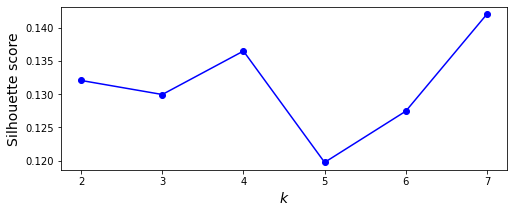

In [17]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

def lineSilhouetteScore(data, lower_, upper_):
    kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(data) for k in range(lower_, upper_)]
    silhouette_scores = [silhouette_score(data, model.labels_) for model in kmeans_per_k]
    plt.figure(figsize=(8, 3))
    plt.plot(range(lower_, upper_), silhouette_scores, "bo-")
    plt.xlabel("$k$", fontsize=14)
    plt.ylabel("Silhouette score", fontsize=14)

lineSilhouetteScore(orgiData, 2, 8)

{2: 167299.8525815419,
 3: 151213.54369252772,
 4: 139475.2542219056,
 5: 132380.459140461,
 6: 126673.02503386652,
 7: 120275.61850858651}

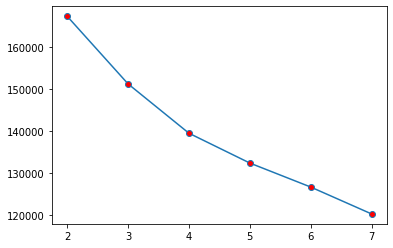

In [18]:
from matplotlib import markers

def showElbow(data, lower_, upper_):
    sse = {}
    for k in range(lower_,upper_):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        sse[k] = kmeans.inertia_
    sse_keys = list(sse.keys())
    sse_values = list(sse.values())
    plt.plot(sse_keys, sse_values, marker='o', markerfacecolor='red')
    return sse

showElbow(orgiData, 2, 8)

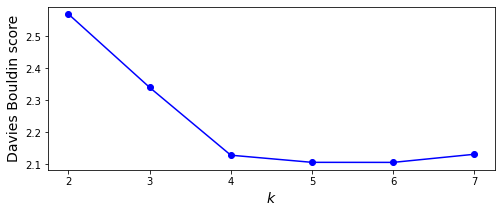

In [19]:
from sklearn.metrics import davies_bouldin_score

def showDaviesBouldinScore(data, lower_, upper_):
    kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(data) for k in range(lower_, upper_)]
    CH_scores = [davies_bouldin_score(data, model.labels_) for model in kmeans_per_k]
    plt.figure(figsize=(8, 3))
    plt.plot(range(lower_, upper_), CH_scores, "bo-")
    plt.xlabel("$k$", fontsize=14)
    plt.ylabel("Davies Bouldin score", fontsize=14)

showDaviesBouldinScore(orgiData, 2, 8)

In [20]:
from sklearn.cluster import KMeans
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
y_pred_kmeans = kmeans.fit_predict(orgiData)
customers['labels'] = y_pred_kmeans

In [21]:
customers_0 = customers[customers['labels']==0]
customers_0.describe(include='all')

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,y,recency,labels
count,8249.000000,8249,8249,8249,8249,8249.000000,8249,8249,8249,8249.000000,8249.000000,8249.000000,8249.000000,8249,8249,8249.000000,8249.0
unique,NaN,12,3,4,2,NaN,2,2,3,NaN,NaN,NaN,NaN,3,2,NaN,NaN
top,NaN,management,married,secondary,no,NaN,yes,no,cellular,NaN,NaN,NaN,NaN,failure,no,NaN,NaN
freq,NaN,1822,4741,4250,8192,NaN,5140,7128,7551,NaN,NaN,NaN,NaN,4901,6346,NaN,NaN
mean,40.952479,NaN,NaN,NaN,NaN,1557.539823,NaN,NaN,NaN,260.076373,2.055764,224.611832,3.175779,NaN,NaN,328.043399,0.0
std,11.423359,NaN,NaN,NaN,NaN,3061.810557,NaN,NaN,NaN,235.171748,1.561477,115.263322,4.558345,NaN,NaN,119.138721,0.0
min,18.000000,NaN,NaN,NaN,NaN,-1884.000000,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,NaN,NaN,1.000000,0.0
25%,33.000000,NaN,NaN,NaN,NaN,167.000000,NaN,NaN,NaN,113.000000,1.000000,133.000000,1.000000,NaN,NaN,268.000000,0.0
50%,38.000000,NaN,NaN,NaN,NaN,603.000000,NaN,NaN,NaN,193.000000,2.000000,195.000000,2.000000,NaN,NaN,371.000000,0.0
75%,48.000000,NaN,NaN,NaN,NaN,1743.000000,NaN,NaN,NaN,324.000000,2.000000,327.000000,4.000000,NaN,NaN,395.000000,0.0


In [22]:
customers_1 = customers[customers['labels']==1]
customers_1.describe(include='all')

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,y,recency,labels
count,10305.000000,10305,10305,10305,10305,10305.000000,10305,10305,10305,10305.000000,10305.000000,10305.000000,10305.000000,10305,10305,10305.000000,10305.0
unique,NaN,12,3,3,2,NaN,2,2,3,NaN,NaN,NaN,NaN,2,2,NaN,NaN
top,NaN,management,married,tertiary,no,NaN,no,no,cellular,NaN,NaN,NaN,NaN,unknown,no,NaN,NaN
freq,NaN,6322,5370,10245,10129,NaN,5718,8923,7598,NaN,NaN,NaN,NaN,10303,9088,NaN,NaN
mean,39.634740,NaN,NaN,NaN,NaN,1712.587579,NaN,NaN,NaN,258.029597,3.032314,-0.973023,0.000776,NaN,NaN,459.267540,1.0
std,9.816084,NaN,NaN,NaN,NaN,3920.948939,NaN,NaN,NaN,271.699057,3.388048,1.930783,0.052123,NaN,NaN,90.164534,0.0
min,20.000000,NaN,NaN,NaN,NaN,-6847.000000,NaN,NaN,NaN,2.000000,1.000000,-1.000000,0.000000,NaN,NaN,1.000000,1.0
25%,32.000000,NaN,NaN,NaN,NaN,86.000000,NaN,NaN,NaN,97.000000,1.000000,-1.000000,0.000000,NaN,NaN,433.000000,1.0
50%,37.000000,NaN,NaN,NaN,NaN,539.000000,NaN,NaN,NaN,170.000000,2.000000,-1.000000,0.000000,NaN,NaN,489.000000,1.0
75%,46.000000,NaN,NaN,NaN,NaN,1722.000000,NaN,NaN,NaN,318.000000,4.000000,-1.000000,0.000000,NaN,NaN,513.000000,1.0


In [23]:
customers_2 = customers[customers['labels']==2]
customers_2.describe(include='all')

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,y,recency,labels
count,15403.000000,15403,15403,15403,15403,15403.000000,15403,15403,15403,15403.000000,15403.000000,15403.000000,15403.000000,15403,15403,15403.000000,15403.0
unique,NaN,12,3,4,2,NaN,1,2,3,NaN,NaN,NaN,NaN,1,2,NaN,NaN
top,NaN,blue-collar,married,secondary,no,NaN,yes,no,unknown,NaN,NaN,NaN,NaN,unknown,no,NaN,NaN
freq,NaN,5664,10011,11179,15095,NaN,15403,12616,7912,NaN,NaN,NaN,NaN,15403,14486,NaN,NaN
mean,39.380445,NaN,NaN,NaN,NaN,1028.837434,NaN,NaN,NaN,262.702266,2.821788,-0.972927,0.000130,NaN,NaN,492.025125,2.0
std,9.093687,NaN,NaN,NaN,NaN,2235.756898,NaN,NaN,NaN,260.218333,3.381068,3.359955,0.016115,NaN,NaN,75.616348,0.0
min,20.000000,NaN,NaN,NaN,NaN,-3313.000000,NaN,NaN,NaN,0.000000,1.000000,-1.000000,0.000000,NaN,NaN,2.000000,2.0
25%,32.000000,NaN,NaN,NaN,NaN,42.000000,NaN,NaN,NaN,106.000000,1.000000,-1.000000,0.000000,NaN,NaN,452.000000,2.0
50%,38.000000,NaN,NaN,NaN,NaN,354.000000,NaN,NaN,NaN,185.000000,2.000000,-1.000000,0.000000,NaN,NaN,530.000000,2.0
75%,46.000000,NaN,NaN,NaN,NaN,1103.000000,NaN,NaN,NaN,322.000000,3.000000,-1.000000,0.000000,NaN,NaN,549.000000,2.0


In [24]:
customers_3 = customers[customers['labels']==3]
customers_3.describe(include='all')

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,y,recency,labels
count,11254.000000,11254,11254,11254,11254,11254.000000,11254,11254,11254,11254.000000,11254.000000,11254.000000,11254.000000,11254,11254,11254.000000,11254.0
unique,NaN,12,3,4,2,NaN,1,2,3,NaN,NaN,NaN,NaN,2,2,NaN,NaN
top,NaN,blue-collar,married,secondary,no,NaN,no,no,cellular,NaN,NaN,NaN,NaN,unknown,no,NaN,NaN
freq,NaN,2369,7092,7773,10980,NaN,11254,9300,7327,NaN,NaN,NaN,NaN,11253,10002,NaN,NaN
mean,44.245335,NaN,NaN,NaN,NaN,1354.730585,NaN,NaN,NaN,250.670251,2.957704,-0.926426,0.002666,NaN,NaN,461.361294,3.0
std,11.838075,NaN,NaN,NaN,NaN,3027.004026,NaN,NaN,NaN,256.028706,3.184287,5.395585,0.209505,NaN,NaN,97.565587,0.0
min,18.000000,NaN,NaN,NaN,NaN,-8019.000000,NaN,NaN,NaN,0.000000,1.000000,-1.000000,0.000000,NaN,NaN,1.000000,3.0
25%,35.000000,NaN,NaN,NaN,NaN,50.000000,NaN,NaN,NaN,98.000000,1.000000,-1.000000,0.000000,NaN,NaN,437.000000,3.0
50%,44.000000,NaN,NaN,NaN,NaN,410.000000,NaN,NaN,NaN,171.000000,2.000000,-1.000000,0.000000,NaN,NaN,495.000000,3.0
75%,53.000000,NaN,NaN,NaN,NaN,1443.000000,NaN,NaN,NaN,310.000000,3.000000,-1.000000,0.000000,NaN,NaN,519.000000,3.0
